In [1]:
import random
import os,shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import kagglehub


In [2]:

# Path where kagglehub stored the dataset
source_path = r"C:\Users\Lenovo\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1\data"

#  desired project folder path
target_path = r"D:\Face Mask Detection\data"

# Create the target folder if it doesn't exist
os.makedirs(target_path, exist_ok=True)

# Copy all files from source to target
if not os.listdir(target_path):  # only copy if empty
    shutil.copytree(source_path, target_path, dirs_exist_ok=True)
    print(f" Dataset copied to: {target_path}")
else:
    print(f" Dataset already exists at: {target_path}")

print(" Subfolders:", os.listdir(target_path))


 Dataset already exists at: D:\Face Mask Detection\data
 Subfolders: ['test', 'train', 'without_mask', 'with_mask']


In [3]:

# Paths
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create train/test directories
for folder in [train_dir, test_dir]:
    for subfolder in ['with_mask', 'without_mask']:
        os.makedirs(os.path.join(folder, subfolder), exist_ok=True)

# Define paths
with_mask_path = os.path.join(base_dir, 'with_mask')
without_mask_path = os.path.join(base_dir, 'without_mask')

# Split ratio
split_ratio = 0.8  # 80% train, 20% test

def split_data(source_dir, train_dir, test_dir):
    images = [img for img in os.listdir(source_dir)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Found {len(images)} images in {source_dir}")
    
    random.shuffle(images)
    split_point = int(len(images) * split_ratio)
    
    train_imgs = images[:split_point]
    test_imgs = images[split_point:]
    
    # Copy train images
    for img in train_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))
    
    # Copy test images
    for img in test_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(test_dir, img))
    
    print(f"Copied {len(train_imgs)} train and {len(test_imgs)} test images from {source_dir}")

# Split both classes
split_data(with_mask_path,
           os.path.join(train_dir, 'with_mask'),
           os.path.join(test_dir, 'with_mask'))

split_data(without_mask_path,
           os.path.join(train_dir, 'without_mask'),
           os.path.join(test_dir, 'without_mask'))

print(" Data splitting complete!")
# Create folder to save trained model
os.makedirs("models", exist_ok=True)
model_path = os.path.join("models", "mask_detector.pth")

# Hyperparameters
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f" Device in use: {DEVICE}")
print(f" Model will be saved at: {model_path}")

Found 3725 images in data\with_mask
Copied 2980 train and 745 test images from data\with_mask
Found 3828 images in data\without_mask
Copied 3062 train and 766 test images from data\without_mask
 Data splitting complete!
 Device in use: cpu
 Model will be saved at: models\mask_detector.pth


In [4]:

#  Image transformations

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


#  Load datasets

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


#  Create dataloaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


# Display dataset info

print(f" Classes: {train_dataset.classes}")
print(f" Training images: {len(train_dataset)}")
print(f" Testing images: {len(test_dataset)}")


 Classes: ['with_mask', 'without_mask']
 Training images: 7562
 Testing images: 6776


In [5]:

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze early layers (optional for faster training)
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 2)  # 2 classes: with_mask, without_mask
)

model = model.to(DEVICE)
print(" Model loaded and customized for 2 classes.")


 Model loaded and customized for 2 classes.


In [6]:
# . Define Loss and Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
#   Training Loop

best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\n Epoch {epoch+1}/{EPOCHS}")
    print("-" * 40)

    # ---- Training ----
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    train_loss /= len(train_dataset)
    train_acc = train_correct.double() / len(train_dataset)



 Epoch 1/5
----------------------------------------


Training:   0%|                                                                                | 0/119 [00:00<?, ?it/s]D:\Face Mask Detection\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training: 100%|██████████████████████████████████████████████████████████████████████| 119/119 [02:40<00:00,  1.35s/it]



 Epoch 2/5
----------------------------------------


Training: 100%|██████████████████████████████████████████████████████████████████████| 119/119 [02:27<00:00,  1.24s/it]



 Epoch 3/5
----------------------------------------


Training: 100%|██████████████████████████████████████████████████████████████████████| 119/119 [02:28<00:00,  1.25s/it]



 Epoch 4/5
----------------------------------------


Training: 100%|██████████████████████████████████████████████████████████████████████| 119/119 [02:29<00:00,  1.26s/it]



 Epoch 5/5
----------------------------------------


Training: 100%|██████████████████████████████████████████████████████████████████████| 119/119 [02:34<00:00,  1.30s/it]


In [8]:
# Validation
model.eval()
val_loss, val_correct = 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)

val_loss /= len(test_dataset)
val_acc = val_correct.double() / len(test_dataset)

print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

# Save best model
if val_acc > best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), model_path)
    print(f" Saved best model (Acc: {best_acc:.4f})")

print("\n Training complete! Best Validation Accuracy: {:.2f}%".format(best_acc * 100))


Validation: 100%|████████████████████████████████████████████████████████████████████| 106/106 [02:10<00:00,  1.23s/it]

Train Loss: 0.1987 | Train Acc: 0.9320
Val Loss:   0.1614 | Val Acc:   0.9516
 Saved best model (Acc: 0.9516)

 Training complete! Best Validation Accuracy: 95.16%


In [9]:
#  Load Best Model for Testing or Inference
# ============================
model.load_state_dict(torch.load(model_path))
model.eval()
print(" Model reloaded successfully")

 Model reloaded successfully


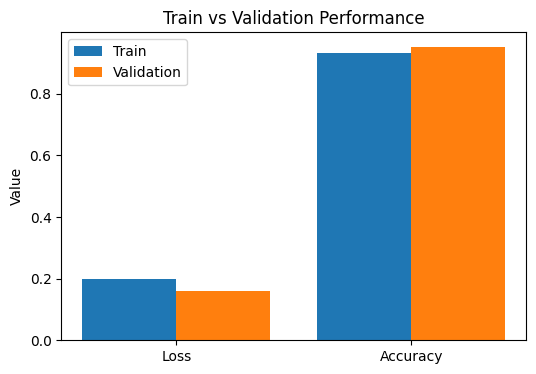

In [10]:
# Plot bar chart for last epoch
import matplotlib.pyplot as plt

# Example: use your last computed values
metrics = ['Loss', 'Accuracy']
train_values = [train_loss, train_acc]
val_values = [val_loss, val_acc]

plt.figure(figsize=(6,4))
x = range(len(metrics))
plt.bar(x, train_values, width=0.4, label='Train', align='center')
plt.bar([p + 0.4 for p in x], val_values, width=0.4, label='Validation', align='center')
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylabel('Value')
plt.title('Train vs Validation Performance')
plt.legend()
plt.show()


D:\Face Mask Detection\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


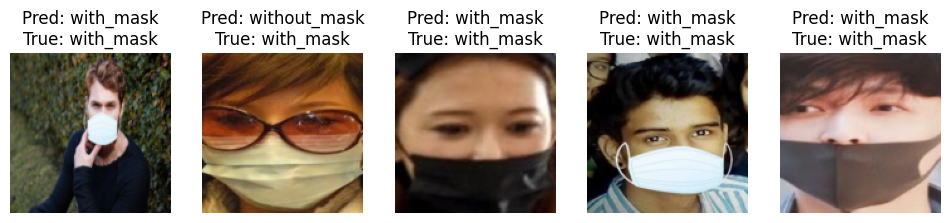

In [11]:
# Visualize Predictions
import matplotlib.pyplot as plt
import numpy as np

# Get a few test samples
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move to device and get predictions
images = images.to(DEVICE)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show first 5 predictions
plt.figure(figsize=(12, 5))
for i in range(5):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                  np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {test_dataset.classes[preds[i]]}\nTrue: {test_dataset.classes[labels[i]]}")
    plt.axis("off")
plt.show()


In [12]:
from collections import Counter
print(Counter(train_dataset.targets))


Counter({1: 3834, 0: 3728})


In [13]:
print(train_dataset.classes)


['with_mask', 'without_mask']
